In [2]:
import pandas as pd
import numpy as np
from itertools import product as prd
import string

from LoadData import read_data, train_test_split
from ARTM_model import EcgClassification
from LinearAlg import naive_bayes, naive_bayes_bin, sindrom_algorithm
from cross_validation import cross_val_score
from statsmodels.stats.weightstats import DescrStatsW
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def plot_data(data, predictors, ind_health, data_dir):
    figure(figsize=(6, 5))
    data_bin = data[predictors] >= 1
    ax = sns.regplot(
                data_bin.iloc[ind_health].mean(axis=0),
                data_bin.iloc[~ind_health].mean(axis=0),
                color='purple',
                scatter_kws={"s": 40})
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_title('mean_gram3_freq', fontsize=15)
    ax.set_xlabel('label0', fontsize=15)
    ax.set_ylabel('label1', fontsize=15)
    #savefig('{}/mean_gram3_freq.png'.format(data_dir))

def plot_fill_between(data, data_dir, label, n_topics=2):
    plt.figure(figsize=(10, 8))
    left_edge = []
    right_edge = []
    mean_res = []
    iters = []
    for key, value in data.items():
        left, right = DescrStatsW(value).tconfint_mean()
        left_edge.append(left)
        right_edge.append(right)
        iters.append(key + 1)
        mean_res.append(np.mean(value))

    fill_between(iters, left_edge, right_edge, color='violet')
    plot(iters, mean_res, color='magenta', lw=5)

    xlabel('iteration', fontsize=18)
    ylabel(label, fontsize=18)
    xlim([1, len(iters)])
    ylim([min(mean_res) - 0.05, max(mean_res) + 0.05])
    xticks(list(xticks()[0][1:]) + [1])
    tick_params(axis='both', which='major', labelsize=18)
    legend(['TrainCV'], fontsize=18, loc='best')
    #plt.savefig('{}/{}_t{}.png'.format(data_dir, label, n_topics))
    show()
    return mean_res

def plot_artm_res(data_dir, auc, logloss, sparsity_phi_c, sparsity_phi_gram3):
    mean_auc = plot_fill_between(auc, data_dir, label='AUC')
    mean_logloss = plot_fill_between(logloss, data_dir, label='LogLoss')

    plt.figure(figsize=(10, 8))
    iters = []
    mean_sparsity_phi_c = []
    mean_sparsity_phi_gram3 = []

    for key, value in sparsity_phi_c.items():
        iters.append(key + 1)
        mean_sparsity_phi_c.append(np.mean(value))

    for key, value in sparsity_phi_gram3.items():
        mean_sparsity_phi_gram3.append(np.mean(value))

    plot(iters, mean_sparsity_phi_c, color='magenta', lw=5)
    plot(iters, mean_sparsity_phi_gram3, color='purple', lw=5)

    xlabel('iteration', fontsize=18)
    xlim([1, len(iters)])

    xticks(list(plt.xticks()[0][1:]) + [1])
    yticks(np.arange(0.0, 1.1, 0.1))
    tick_params(axis='both', which='major', labelsize=18)
    ylabel('Sparsity', fontsize=18)
    legend([r'$p(c|t)$', r'$p(gram3|t)$'], loc = 'best', fontsize = 15)
    #plt.savefig('{}/sparsity_t{}.png'.format(data_dir, n_topics))
    plt.show()
    return mean_auc[-1], mean_logloss[-1], mean_sparsity_phi_c[-1], mean_sparsity_phi_gram3[-1]

ММЭ:(626, 218)
0
1
2
3
4
5
6
7
8
9


/home/dasha/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/dasha/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


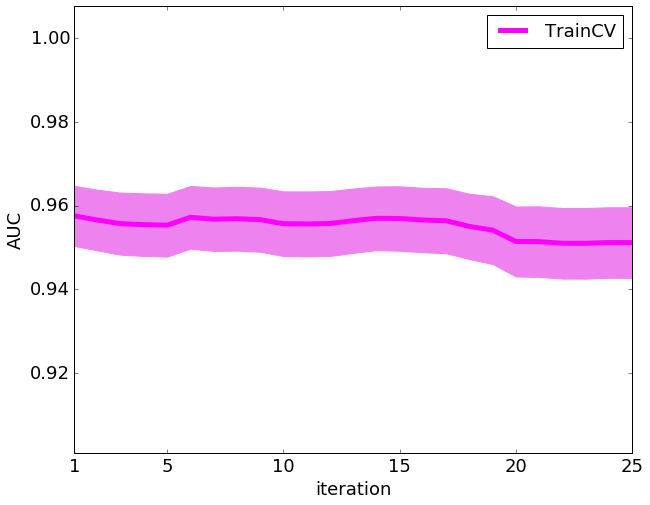

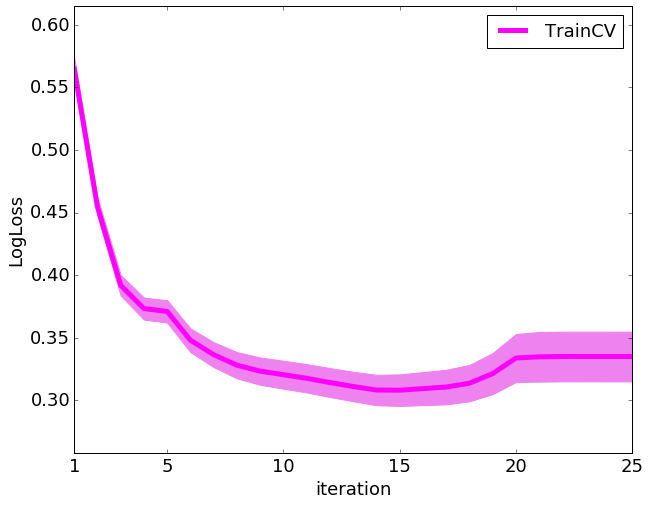

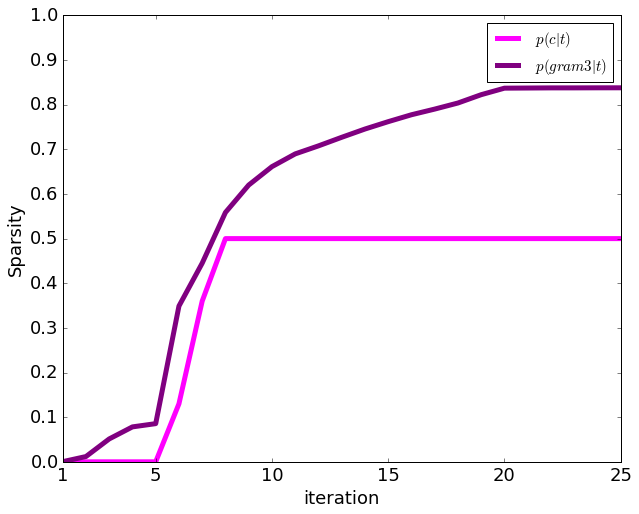

In [4]:
disease = pd.read_csv('auc_disease.csv', index_col=0)[['Болезнь', 'n_dis']].values
predictors = np.load('predictors.npy') 

n_topics = 2
n_topics_health = 1
n_health = 1

tau_phi_gram3 =  np.hstack(([0] * 5, np.linspace(-1e2, -1e3, 15), [-1e3] * 5))
tau = np.hstack((
          np.repeat([1e2, 1e2 * 5], [5, 5]),
          np.repeat([1e3, 1e3 * 5], [5, 5]),
          np.repeat([1e4], [5])
          ))
res = {}
for data_dir, n_dis in disease[1:2]:
    res[data_dir] = {}
    data_all, target = read_data(n_dis, n_health, data_dir, predictors)
    print ('{}:{}'.format(data_dir, data_all.shape))
    X_train, y_train, X_valid, y_valid = train_test_split(data_all, predictors, target, data_dir)
    #plot_data(data_all, predictors, np.nonzero((data_all[target] == 0))[0], data_dir)

    best_key, auc, logloss = cross_val_score(sindrom_algorithm, data_dir, type_weights=1)
    res[data_dir]['SA_type_weights:1'] = {}
    res[data_dir]['SA_type_weights:1']['AUC(TrainCV)'] = auc
    res[data_dir]['SA_type_weights:1']['LogLoss(TrainCV)'] = logloss

    best_key, auc, logloss = cross_val_score(sindrom_algorithm, data_dir, type_weights=2)
    res[data_dir]['SA_type_weights:2'] = {}
    res[data_dir]['SA_type_weights:2']['AUC(TrainCV)'] = auc
    res[data_dir]['SA_type_weights:2']['LogLoss(TrainCV)'] = logloss

    best_key, auc, logloss = cross_val_score(naive_bayes, data_dir)
    res[data_dir]['NB'] = {}
    res[data_dir]['NB']['AUC(TrainCV)'] = auc
    res[data_dir]['NB']['LogLoss(TrainCV)'] = logloss

    best_key, auc, logloss = cross_val_score(naive_bayes_bin, data_dir)
    res[data_dir]['NB_bin'] = {}
    res[data_dir]['NB_bin']['AUC(TrainCV)'] = auc
    res[data_dir]['NB_bin']['LogLoss(TrainCV)'] = logloss
    
    clf = EcgClassification(data_dir, 
                            data_all.shape[0],
                            n_topics,
                            n_topics_health)
    
    artm_scores = clf.cross_val_score(tau, tau_phi_gram3)
    auc, logloss, sparsity_phi_c, sparsity_phi_gram3 = plot_artm_res(
                                                           data_dir,
                                                           artm_scores[0],
                                                           artm_scores[1],
                                                           artm_scores[2],
                                                           artm_scores[3])
    res[data_dir]['ARTM_t{}'.format(n_topics)] = {}
    res[data_dir]['ARTM_t{}'.format(n_topics)]['AUC(TrainCV)'] = auc
    res[data_dir]['ARTM_t{}'.format(n_topics)]['LogLoss(TrainCV)'] = logloss